In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt

import sys
sys.path.append("../../")

import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1)

In [2]:
models = torch.load("model/loden_activation.pt")

symODE_tanh, symODE_sigmoid, symODE_relu, symODE_softplus = models

symODE_tanh.eval()
symODE_sigmoid.eval()
symODE_relu.eval()
symODE_softplus.eval()

None

In [3]:
test_set = torch.load('data/SHM_test_set.pt')
train_set = torch.load('data/SHM_training_set.pt')[:300]

In [4]:
from torchdyn.models import NeuralODE

from module import LNN
from nn import MLP, PSD

lagFunc_softplus = LNN(num_angle=0, lagrangianNet=MLP([2, 32, 33, 1], activation='softplus'))
lagODE_softplus = NeuralODE(lagFunc_softplus, sensitivity='adjoint', solver='rk4').to(device)

### Get test err

In [5]:
test_err = []
train_err = []
test_t_span = test_set[0, :, -1]
train_t_span = train_set[0, :, -1]

for model in models:
    test_traj = model.trajectory(test_set[:, 0, 0:2], test_t_span).transpose(0,1)
    test_loss = torch.nn.functional.mse_loss(test_traj, test_set[:, :, 0:2])
    
    train_traj = model.trajectory(train_set[:, 0, 0:2], train_t_span).transpose(0,1)
    train_loss = torch.nn.functional.mse_loss(train_traj, train_set[:, :, 0:2])
    
    test_err.append(test_loss)
    train_err.append(train_loss)

In [6]:
for i in range(4):
    print(train_err[i])
    print(test_err[i])

tensor(1.6093e-06, grad_fn=<MseLossBackward>)
tensor(32.7986, grad_fn=<MseLossBackward>)
tensor(1.5823e-07, grad_fn=<MseLossBackward>)
tensor(8.3803, grad_fn=<MseLossBackward>)
tensor(0.0005, grad_fn=<MseLossBackward>)
tensor(48.8968, grad_fn=<MseLossBackward>)
tensor(1.3884e-05, grad_fn=<MseLossBackward>)
tensor(5.6719, grad_fn=<MseLossBackward>)


Epoch till converge: 1181 3378 700 759
train err: 1.61e-06 1.77e-07 0.000466 1.38e-05

### Phase Portrait

In [20]:
test_model = models[1]

In [8]:
with torch.no_grad():
    n_grid = 100
    x = torch.linspace(-5.5, 5.5, n_grid)
    Q, dQ = torch.meshgrid(x, x)  # all (q, p)

    L, U, V = torch.zeros(Q.shape), torch.zeros(Q.shape), torch.zeros(Q.shape)

    for i in range(n_grid):
        for j in range(n_grid):
            x = torch.cat([Q[i, j].reshape(1, 1), dQ[i, j].reshape(1, 1)], 1)
            L[i, j] = test_model.defunc.m.L(x)
            grad = test_model.defunc(0, x).detach().cpu()
            U[i, j], V[i, j] = grad[:, 0], grad[:, 1]

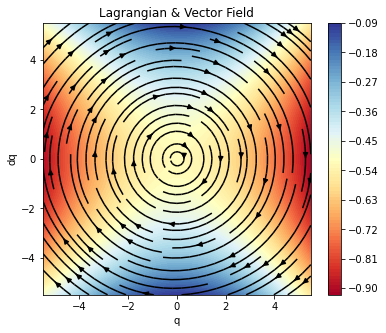

In [9]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
CS = ax.contourf(Q, dQ, L, 100, cmap='RdYlBu')
fig.colorbar(CS)

ax.streamplot(Q.T.numpy(), dQ.T.numpy(), U.T.numpy(), V.T.numpy(), color='black')

ax.set_xlim([Q.min(), Q.max()])
ax.set_ylim([dQ.min(), dQ.max()])
ax.set_xlabel("q")
ax.set_ylabel("dq")
ax.set_title("Lagrangian & Vector Field")
None

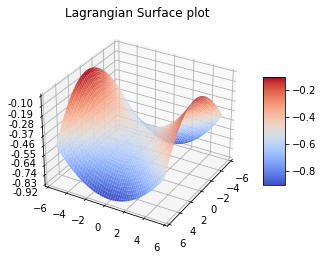

In [10]:
# Plot the surface
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(Q.numpy(), dQ.numpy(), L.numpy(), cmap='coolwarm')

# Customize the z axis.
ax.set_zlim(L.min(), L.max())
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')
ax.view_init(30, 30)

ax.set_title("Lagrangian Surface plot")

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

None

### Trajectory Test

In [11]:
from utils import SHM_1D_model

In [12]:
# Generate Trajectory from true model
t0 = 0
dt = 0.05
steps = 200
t1 = int(dt * steps)

q_p1, dq_dp, _, ts = SHM_1D_model(x0=1.5, p0=1.5, t0=t0, t1=t1, steps=steps)
q_p2, dq_dp, _, ts = SHM_1D_model(x0=4, p0=4, t0=t0, t1=t1, steps=steps)


# Generate Estimated Trajectory
t_span = torch.linspace(t0, t1, steps)

traj1_tanh = models[0].trajectory(q_p1[[0], :], t_span).detach()  # (time, points, dim)
traj1_sigmoid = models[1].trajectory(q_p1[[0], :], t_span).detach()  # (time, points, dim)
traj1_relu = models[2].trajectory(q_p1[[0], :], t_span).detach()  # (time, points, dim)
traj1_softplus = models[3].trajectory(q_p1[[0], :], t_span).detach()  # (time, points, dim)

traj2_tanh = models[0].trajectory(q_p2[[0], :], t_span).detach()  # (time, points, dim)
traj2_sigmoid = models[1].trajectory(q_p2[[0], :], t_span).detach()  # (time, points, dim)
traj2_relu = models[2].trajectory(q_p2[[0], :], t_span).detach()  # (time, points, dim)
traj2_softplus = models[3].trajectory(q_p2[[0], :], t_span).detach()  # (time, points, dim)

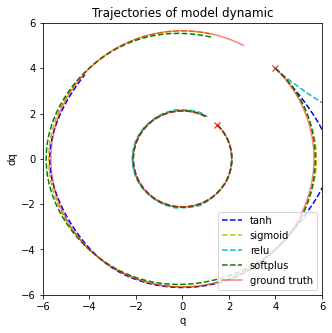

In [13]:
# Plot the trajectory generated from the model
# Phase Plot
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(111)

length = 120
ax1.plot(q_p1[0, 0], q_p1[0, 1], marker='x', color="red")  # init pos
ax1.plot(q_p2[0, 0], q_p2[0, 1], marker='x', color="red")  # init pos

ax1.plot(traj1_tanh[:length, 0, 0], traj1_tanh[:length, 0, 1], 'b--', label='tanh')
ax1.plot(traj1_sigmoid[:length, 0, 0], traj1_sigmoid[:length, 0, 1], 'y--', label='sigmoid')
ax1.plot(traj1_relu[:length, 0, 0], traj1_relu[:length, 0, 1], 'c--', label='relu')
ax1.plot(traj1_softplus[:length, 0, 0], traj1_softplus[:length, 0, 1], 'g--', label='softplus')
ax1.plot(q_p1[:length, 0], q_p1[:length, 1], color='red', alpha=0.5, label='ground truth')

ax1.plot(traj2_tanh[:length, 0, 0], traj2_tanh[:length, 0, 1], 'b--')
ax1.plot(traj2_sigmoid[:length, 0, 0], traj2_sigmoid[:length, 0, 1], 'y--')
ax1.plot(traj2_relu[:length, 0, 0], traj2_relu[:length, 0, 1], 'c--')
ax1.plot(traj2_softplus[:length, 0, 0], traj2_softplus[:length, 0, 1], 'g--')
ax1.plot(q_p2[:length, 0], q_p2[:length, 1], color='red', alpha=0.5)

ax1.set_xlim([-6., 6.])
ax1.set_ylim([-6., 6.])
ax1.set_xlabel("q")
ax1.set_ylabel("dq")
ax1.legend(loc='lower right')
ax1.set_title("Trajectories of model dynamic")

None

### Hamiltonian

In [14]:
with torch.no_grad():
    n_grid = 100
    x = torch.linspace(-4.5, 4.5, n_grid)
    Q, dQ = torch.meshgrid(x, x)  # all (q, p)

    # H is Hamiltonian
    # (U, V) are the symplectic gradient
    H, U, V = torch.zeros(Q.shape), torch.zeros(Q.shape), torch.zeros(Q.shape)

    P = torch.zeros_like(dQ)

    for i in range(n_grid):
        for j in range(n_grid):
            # The current canonical coordinate
            x = torch.cat([Q[i, j].reshape(1, 1), dQ[i, j].reshape(1, 1)], 1)
            H[i, j]= test_model.defunc.m.Structured_H(x)
            grad = test_model.defunc(0, x)
            U[i, j], V[i, j] = grad[:, 0], grad[:, 1]


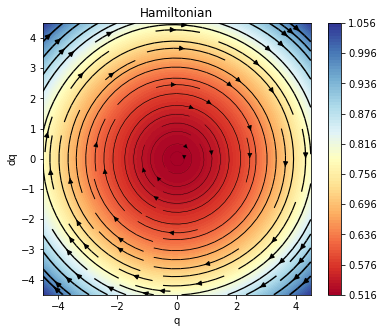

In [15]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
CS = ax.contourf(Q, dQ, H, 100, cmap='RdYlBu')
fig.colorbar(CS)
lw = np.sqrt(U ** 2 + V ** 2).detach().numpy()
lw = lw / lw.mean()
ax.streamplot(Q.T.numpy(), dQ.T.numpy(), U.T.numpy(), V.T.numpy(), color='black', linewidth=lw)

ax.set_xlim([Q.min(), Q.max()])
ax.set_ylim([dQ.min(), dQ.max()])
ax.set_xlabel("q")
ax.set_ylabel("dq")
ax.set_title("Hamiltonian")
None

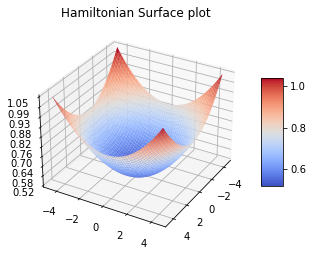

In [16]:
# Plot the surface
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(Q.numpy(), dQ.numpy(), H.numpy(), cmap='coolwarm')

# Customize the z axis.
ax.set_zlim(H.min(), H.max())
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')
ax.view_init(30, 30)

ax.set_title("Hamiltonian Surface plot")

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

None

### s-t v-t

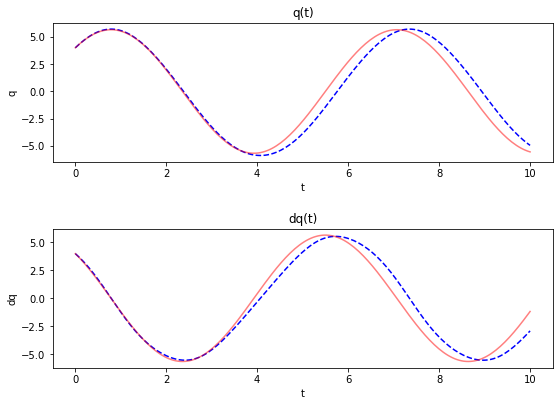

In [17]:
# Plot q(t) and p(t) graph
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(211)

ax1.plot(t_span, traj2_softplus[:, 0, 0], '--', color='blue')  # traj
ax1.plot(t_span, q_p2[:, 0], color='red', alpha=0.5)  # traj

ax1.set_xlabel("t")
ax1.set_ylabel("q")
ax1.set_title("q(t)")

ax2 = fig.add_subplot(212)
ax2.plot(t_span, traj2_softplus[:, 0, 1], '--', color='blue')  # traj
ax2.plot(t_span, q_p2[:, 1], color='red', alpha=0.5)  # traj

ax2.set_xlabel("t")
ax2.set_ylabel("dq")
ax2.set_title("dq(t)")

fig.tight_layout(pad=2.0)
None

### Mass and potential

In [21]:
test_model = models[1]

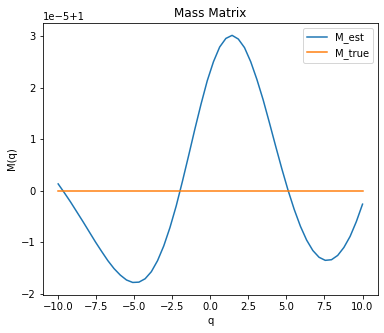

In [22]:
n_grid = 50
x = torch.linspace(-10, 10, n_grid)

M_est = torch.zeros(x.shape)

for i in range(n_grid):
    M_est[i] = test_model.defunc.m.massMatrixNet(x[i].view(1, 1)).detach().cpu()[0, 0, 0]

    
M_true = torch.ones(M_est.shape)
M_est2 = M_est + (M_true - M_est.mean())

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.plot(x.detach().numpy(), M_est2, label='M_est')
ax.plot(x.detach().numpy(), M_true, label='M_true')

ax.legend()
# ax.set_ylim([0, 1.1])
ax.set_xlabel("q")
ax.set_ylabel("M(q)")
ax.set_title("Mass Matrix")
None

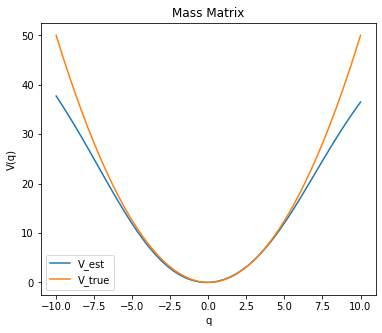

In [23]:
n_grid = 50
x = torch.linspace(-10., 10., n_grid)

V_true = 0.5 * 1. * x ** 2 

V_est = torch.zeros(x.shape)

for i in range(n_grid):
    V_est[i] = test_model.defunc.m.potentialNet(x[i].view(1, 1)).detach().cpu()/M_est[i]

V_est = V_est - min(V_est)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.plot(x.detach().numpy(), V_est, label='V_est')
ax.plot(x.detach().numpy(), V_true, label='V_true')

ax.legend()
ax.set_xlabel("q")
ax.set_ylabel("V(q)")
ax.set_title("Mass Matrix")
None